## Goals:
1. Generate some data to train on 
    - pick a mean (keep variance fixed) and some change points
    - generate a large length of x values
2. Detect changepoints


## Next:
1. implement segment detection (not just changepoint detection)


In [1]:
import math
import numpy as np
import scipy.stats
from functools import partial

In [2]:
class BOCD(object):
    def __init__(self, hazard_function, observation_likelihood):
        """Initializes th detector with zero observations.
        """
        self.t0 = 0
        self.t = -1
        self.growth_probs = np.array([1.])
        self.hazard_function = hazard_function
        self.observation_likelihood = observation_likelihood

    def update(self, x):
        """Updates changepoint probabilities with a new data point.
        """
        self.t += 1

        t = self.t - self.t0
        
        # Change length of array
        temp = self.growth_probs
        self.growth_probs = np.zeros(t+2)
        self.growth_probs[:(t+1)] = temp[:(t+1)]

        # Evaluate the predictive distribution for the new datum under each of
        # the parameters.  This is the standard thing from Bayesian inference.
        pred_probs = self.observation_likelihood.pdf(x)

        # Evaluate the hazard function for this interval
        H = self.hazard_function(np.array(range(t + 1)))

        # Evaluate the probability that there *was* a changepoint and we're
        # accumulating the mass back down at r = 0.
        cp_prob = np.sum(self.growth_probs[0:t + 1] * pred_probs * H)

        # Evaluate the growth probabilities - shift the probabilities down and to
        # the right, scaled by the hazard function and the predictive
        # probabilities.
        self.growth_probs[1:t + 2] = self.growth_probs[0:t + 1] * pred_probs * (1-H)
        # Put back changepoint probability
        self.growth_probs[0] = cp_prob

        # Renormalize the run length probabilities for improved numerical
        # stability.
        self.growth_probs[:] = self.growth_probs[:] / \
            np.sum(self.growth_probs[:])

        # Update the parameter sets for each possible run length.
        self.observation_likelihood.update_theta(x)

    def prune(self, t0):
        """prunes memory before time t0. That is, pruning at t=0
        does not change the memory. One should prune at times
        which are likely to correspond to changepoints.
        """
        self.t0 = t0
        self.observation_likelihood.prune(self.t - t0 + 1)


def constant_hazard(lam, r):
    """Computes the "constant" hazard, that is corresponding
    to Poisson process.
    """
    return 1/lam * np.ones(r.shape)

In [3]:
class StudentT:
    """Student's t predictive posterior.
    """
    def __init__(self, alpha, beta, kappa, mu):
        self.alpha0 = self.alpha = np.array([alpha])
        self.beta0 = self.beta = np.array([beta])
        self.kappa0 = self.kappa = np.array([kappa])
        self.mu0 = self.mu = np.array([mu])

    def pdf(self, data):
        """PDF of the predictive posterior.
        """
        return scipy.stats.t.pdf(x=data,
                                 df=2*self.alpha,
                                 loc=self.mu,
                                 scale=np.sqrt(self.beta * (self.kappa+1) /
                                                  (self.alpha * self.kappa)))

    def update_theta(self, data):
        """Bayesian update.
        """
        muT0 = np.concatenate((self.mu0, (self.kappa * self.mu + data) /
                                            (self.kappa + 1)))
        kappaT0 = np.concatenate((self.kappa0, self.kappa + 1.))
        alphaT0 = np.concatenate((self.alpha0, self.alpha + 0.5))
        betaT0 = np.concatenate((self.beta0,
                                    self.beta +
                                    (self.kappa * (data - self.mu)**2) /
                                    (2. * (self.kappa + 1.))))

        self.mu = muT0
        self.kappa = kappaT0
        self.alpha = alphaT0
        self.beta = betaT0
        
    def prune(self, t):
        """Prunes memory before t.
        """
        self.mu = self.mu[:t + 1]
        self.kappa = self.kappa[:t + 1]
        self.alpha = self.alpha[:t + 1]
        self.beta = self.beta[:t + 1]

# Generate data to detect changepoints

In [16]:
xs = np.random.normal(size=1000)
xs[len(xs) // 4:len(xs) // 2] += 10.
xs[len(xs) // 2:3 * len(xs) // 4] -= 10. 
xs = xs/30
xs = xs +0.5

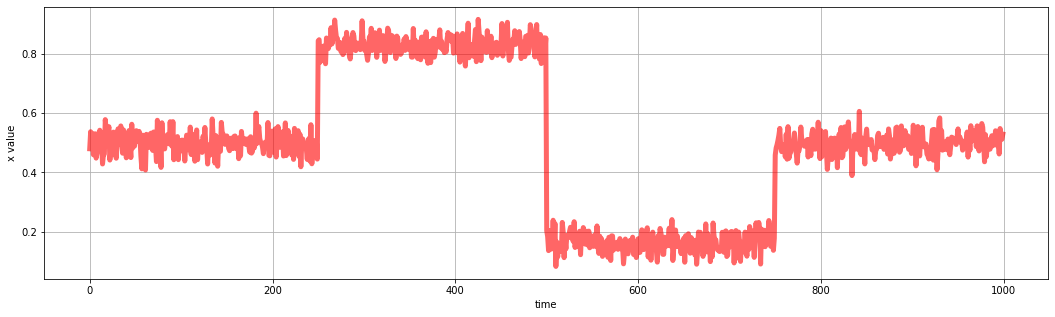

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 5))
# plt.subplot(121)
plt.plot(xs,'r-', lw=5, alpha=0.6, label='t pdf')
plt.ylabel('x value')
plt.xlabel('time')
plt.grid('on')
plt.show()

# Run BOCPD

In [18]:
LAMBDA = 100
ALPHA = 0.1
BETA = 1.
KAPPA = 1.
MU = 0.
DELAY = 15
THRESHOLD = 0.5

bocd = BOCD(partial(constant_hazard, LAMBDA),
                StudentT(ALPHA, BETA, KAPPA, MU))
changepoints = []
list_of_p_r = []
for x_t in xs[:DELAY]:
    bocd.update(x_t)
    list_of_p_r.append(bocd.growth_probs)
    
for x_t in xs[DELAY:]:
    bocd.update(x_t)    
    if (abs(sum(bocd.growth_probs) -1)>0.0001):
        print("Error: Prob sum is not 1. Sum is", sum(bocd.growth_probs))
    list_of_p_r.append(bocd.growth_probs)
    if bocd.growth_probs[DELAY] >= THRESHOLD:
        changepoints.append(bocd.t - DELAY + 1)
        print("Changepoint found at ",changepoints[-1],"\n")
#         bocd.prune(bocd.t - DELAY)

Changepoint found at  250 

Changepoint found at  500 

Changepoint found at  750 



# Plot run length probability evolution

In [19]:
# Construct matrix for plotting
T = 1000
plot_mat = np.zeros((T,T+1))

for i in range(T):
    for j in range(i+1):
        if j>=np.size(list_of_p_r[i]):
            plot_mat[j,i] = 0.
        else:
            plot_mat[j,i] = list_of_p_r[i][j]

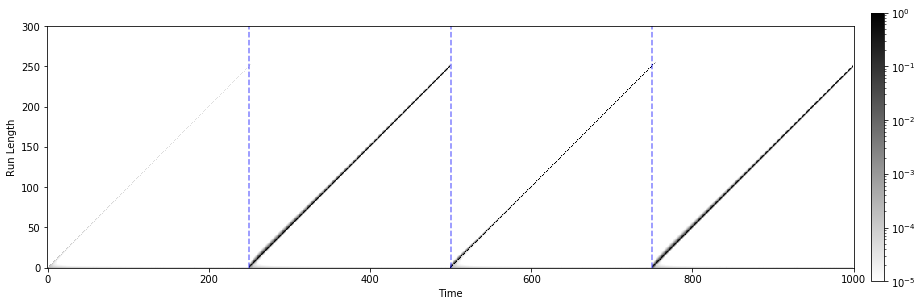

In [20]:
# Create the other figure with run length in the paper
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 300
            
fig, ax = plt.subplots(1,1,figsize=(15, 10))
ax.imshow(plot_mat,interpolation='nearest',cmap=cm.Greys,norm=LogNorm(vmin=1e-5,vmax=1))

ymax = 300
        
for r in [250,500,750]:
    ax.plot([r,r],[0, ymax],'b',linestyle='--',alpha=0.5)

ax.invert_yaxis()
ax.set_ylim((0,ymax))
ax.set_ylabel("Run Length")
ax.set_xlabel("Time")
fig.colorbar(cm.ScalarMappable(norm=LogNorm(vmin=1e-5,vmax=1), cmap=cm.binary), ax=ax, orientation="vertical", pad=0.02, fraction=0.018/1.121)

plt.show()

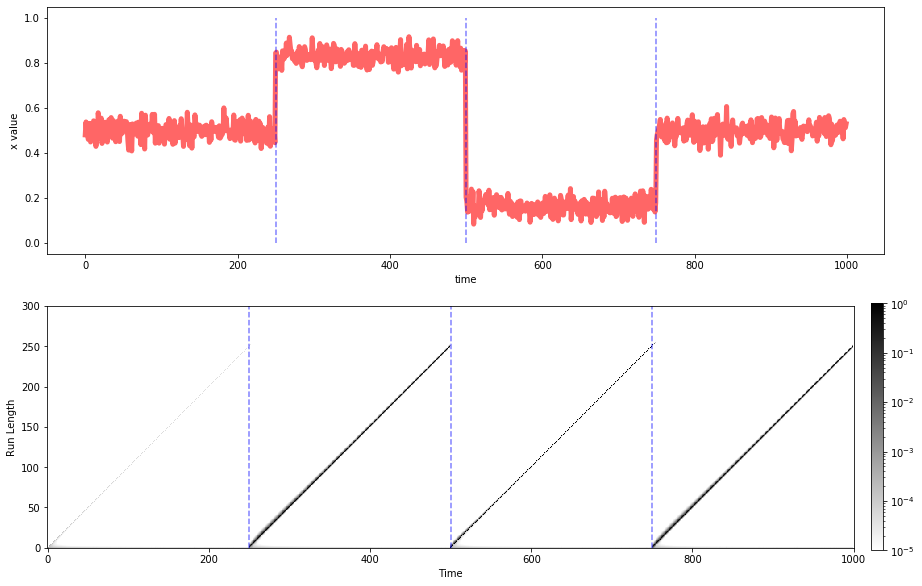

In [21]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,1,figsize=(15, 10))
ax = axs[0]
ax.plot(xs,'r-', lw=5, alpha=0.6, label='t pdf')
for r in [250,500,750]:
    ax.plot([r,r],[0, 1],'b',linestyle='--',alpha=0.5)
ax.set_ylabel('x value')
ax.set_xlabel('time')

ax = axs[1]
ax.imshow(plot_mat,interpolation='nearest',cmap=cm.Greys,norm=LogNorm(vmin=1e-5,vmax=1))

ymax = 300
        
for r in [250,500,750]:
    ax.plot([r,r],[0, ymax],'b',linestyle='--',alpha=0.5)

ax.invert_yaxis()
ax.set_ylim((0,ymax))
ax.set_ylabel("Run Length")
ax.set_xlabel("Time")
fig.colorbar(cm.ScalarMappable(norm=LogNorm(vmin=1e-5,vmax=1), cmap=cm.binary), ax=ax, orientation="vertical", pad=0.02, fraction=0.018/1.121)

plt.show()

# Another set of data

In [53]:
# Generate some data with 0.01 std dev around 0.1, then 0.3, then 0.7, then 0.5
sigma = 0.05 # standard deviation
mu= 0.1 # mean 
a = np.random.normal(mu, sigma, 400)
mu= 0.3 # mean 
b = np.random.normal(mu, sigma, 100)
mu= 0.8 # mean 
c = np.random.normal(mu, sigma, 250)
mu= 0.5 # mean 
d = np.random.normal(mu, sigma, 250)
x_series = np.concatenate([a, b, c, d])

# Run BOCPD

In [54]:
LAMBDA = 100
ALPHA = 0.1
BETA = 1.
KAPPA = 1.
MU = 0.
DELAY = 15
THRESHOLD = 0.5

bocd = BOCD(partial(constant_hazard, LAMBDA),
                StudentT(ALPHA, BETA, KAPPA, MU))
changepoints = []
list_of_p_r = []
for x_t in x_series[:DELAY]:
    bocd.update(x_t)
    list_of_p_r.append(bocd.growth_probs)
    
for x_t in x_series[DELAY:]:
    bocd.update(x_t)    
    if (abs(sum(bocd.growth_probs) -1)>0.0001):
        print("Error: Prob sum is not 1. Sum is", sum(bocd.growth_probs))
    list_of_p_r.append(bocd.growth_probs)
    if bocd.growth_probs[DELAY] >= THRESHOLD:
        changepoints.append(bocd.t - DELAY + 1)
        print("Changepoint found at ",changepoints[-1],"\n")
#         bocd.prune(bocd.t - DELAY)

Changepoint found at  400 

Changepoint found at  500 

Changepoint found at  750 



# Plot run length probability evolution

In [55]:
# Construct matrix for plotting
T = 1000
plot_mat = np.zeros((T,T+1))

for i in range(T):
    for j in range(i+1):
        if j>=np.size(list_of_p_r[i]):
            plot_mat[j,i] = 0.
        else:
            plot_mat[j,i] = list_of_p_r[i][j]

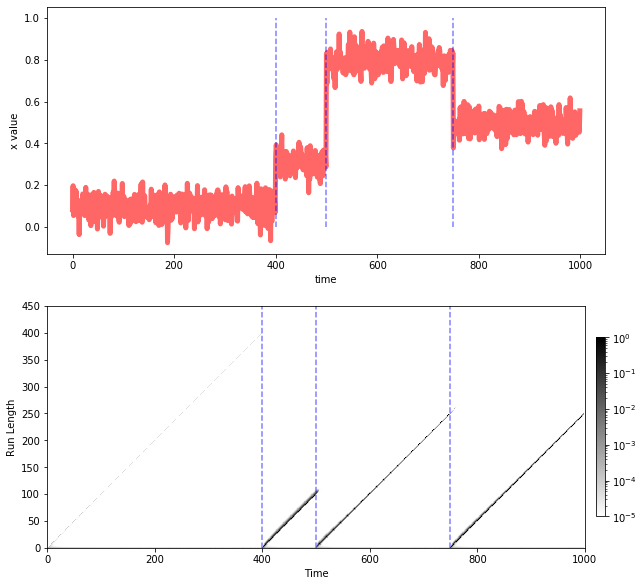

In [56]:
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,1,figsize=(10, 10))
ax = axs[0]
ax.plot(x_series,'r-', lw=5, alpha=0.6, label='t pdf')
for r in [400,500,750]:
    ax.plot([r,r],[0, 1],'b',linestyle='--',alpha=0.5)
ax.set_ylabel('x value')
ax.set_xlabel('time')

ax = axs[1]
ax.imshow(plot_mat,interpolation='nearest',cmap=cm.Greys,norm=LogNorm(vmin=1e-5,vmax=1))

ymax = 450
ax.invert_yaxis()

for r in [400,500,750]:
    ax.plot([r,r],[0, ymax],'b',linestyle='--',alpha=0.5)

ax.set_ylim((0,ymax))
ax.set_ylabel("Run Length")
ax.set_xlabel("Time")
fig.colorbar(cm.ScalarMappable(norm=LogNorm(vmin=1e-5,vmax=1), cmap=cm.binary), ax=ax, orientation="vertical", pad=0.02, fraction=0.018/1.121)

plt.show()

# Another set of data

In [57]:
# Generate some data with 0.01 std dev around 0.1, then 0.3, then 0.7, then 0.5
sigma = 0.05 # standard deviation
mu= 0.1 # mean 
a = np.random.normal(mu, sigma, 400)
mu= 0.2 # mean 
b = np.random.normal(mu, sigma, 50)
mu= 0.3 # mean 
c = np.random.normal(mu, sigma, 50)
mu= 0.8 # mean 
d = np.random.normal(mu, sigma, 250)
mu= 0.5 # mean 
e = np.random.normal(mu, sigma, 250)
x_series = np.concatenate([a, b, c, d, e])

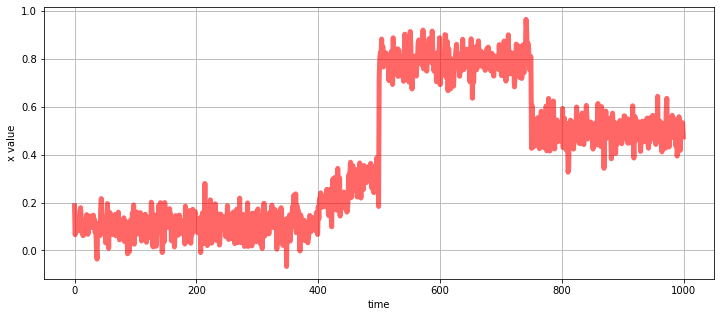

In [58]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
# plt.subplot(121)
plt.plot(x_series,'r-', lw=5, alpha=0.6, label='t pdf')
plt.ylabel('x value')
plt.xlabel('time')
plt.grid('on')
plt.show()

# Run BOCPD

In [59]:
LAMBDA = 100
ALPHA = 0.1
BETA = 1.
KAPPA = 1.
MU = 0.
DELAY = 15
THRESHOLD = 0.5

bocd = BOCD(partial(constant_hazard, LAMBDA),
                StudentT(ALPHA, BETA, KAPPA, MU))
changepoints = []
list_of_p_r = []
for x_t in x_series[:DELAY]:
    bocd.update(x_t)
    list_of_p_r.append(bocd.growth_probs)
    
for x_t in x_series[DELAY:]:
    bocd.update(x_t)    
    if (abs(sum(bocd.growth_probs) -1)>0.0001):
        print("Error: Prob sum is not 1. Sum is", sum(bocd.growth_probs))
    list_of_p_r.append(bocd.growth_probs)
    if bocd.growth_probs[DELAY] >= THRESHOLD:
        changepoints.append(bocd.t - DELAY + 1)
        print("Changepoint found at ",changepoints[-1],"\n")
#         bocd.prune(bocd.t - DELAY)

Changepoint found at  500 

Changepoint found at  750 



# Plot run length probability evolution

In [60]:
# Construct matrix for plotting
T = 1000
plot_mat = np.zeros((T,T+1))

for i in range(T):
    for j in range(i+1):
        if j>=np.size(list_of_p_r[i]):
            plot_mat[j,i] = 0.
        else:
            plot_mat[j,i] = list_of_p_r[i][j]

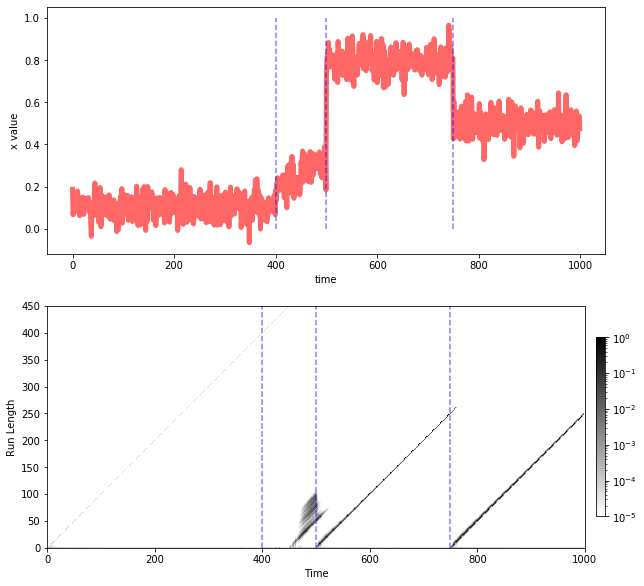

In [61]:
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,1,figsize=(10, 10))
ax = axs[0]
ax.plot(x_series,'r-', lw=5, alpha=0.6, label='t pdf')
for r in [400,500,750]:
    ax.plot([r,r],[0, 1],'b',linestyle='--',alpha=0.5)
ax.set_ylabel('x value')
ax.set_xlabel('time')

ax = axs[1]
ax.imshow(plot_mat,interpolation='nearest',cmap=cm.Greys,norm=LogNorm(vmin=1e-5,vmax=1))

ymax = 450
ax.invert_yaxis()

for r in [400,500,750]:
    ax.plot([r,r],[0, ymax],'b',linestyle='--',alpha=0.5)

ax.set_ylim((0,ymax))
ax.set_ylabel("Run Length")
ax.set_xlabel("Time")
fig.colorbar(cm.ScalarMappable(norm=LogNorm(vmin=1e-5,vmax=1), cmap=cm.binary), ax=ax, orientation="vertical", pad=0.02, fraction=0.018/1.121)

plt.show()

# Sanity check the probabilities

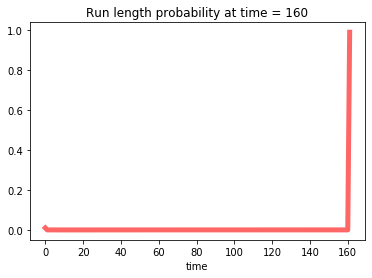

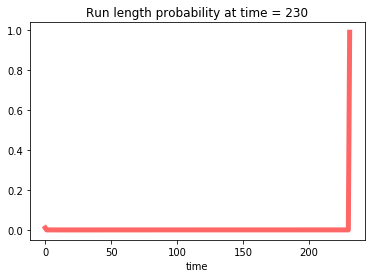

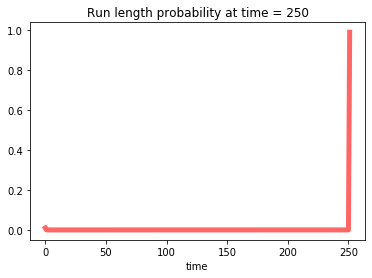

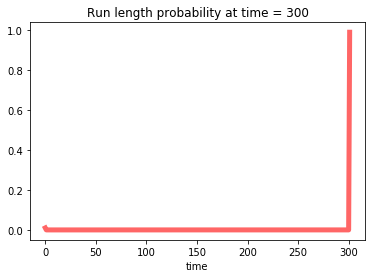

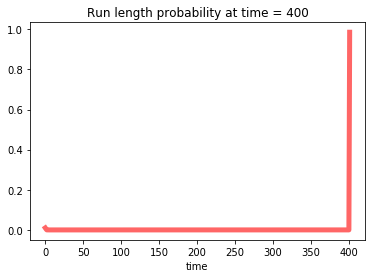

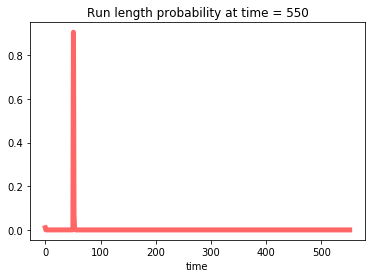

In [13]:
times = [160, 230, 250, 300, 400, 550]
for time in times:
    plt.plot(list_of_p_r[time],'r-', lw=5, alpha=0.6, label='run length pdf')
    plt.title('Run length probability at time = %d'%time)
    plt.xlabel('time')
    plt.show()

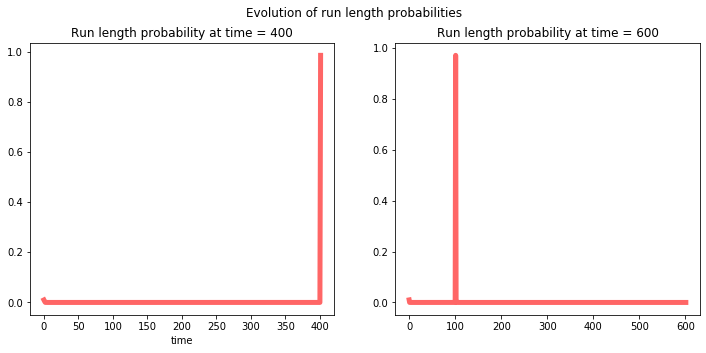

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

plt.subplot(121)
time = 400
plt.plot(list_of_p_r[time],'r-', lw=5, alpha=0.6, label='run length pdf')
plt.title('Run length probability at time = %d'%time)
plt.xlabel('time')
plt.subplot(122)
time = 600
plt.plot(list_of_p_r[time],'r-', lw=5, alpha=0.6, label='run length pdf')
plt.title('Run length probability at time = %d'%time)
plt.suptitle('Evolution of run length probabilities')
plt.show()

# fig, ax = plt.subplots(1, 2)
# plt.plot(x,'r-', lw=5, alpha=0.6, label='t pdf')
# plt.ylabel('some numbers')
# plt.show()